# Proje Amacı

**Bu proje çeşitli faktörleri göz önüne alarak kalp hastalığı tahmini yapmaya çalışır. Makine öğrenmesi tekniklerinden Denetimli ve Denetimsiz öğrenme algoritmaları kullanılarak tahmin üzerindeki başarıları gözlemlenmiştir.**

# Kütüphaneler ve Veri Seti Okuma

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import adjusted_rand_score, v_measure_score

warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv("/kaggle/input/personal-key-indicators-of-heart-disease/2020/heart_2020_cleaned.csv")

# EDA(Keşifçi Veri Analizi)

**Veri Seti Hakkında Gözlemler**

In [33]:
df.shape

(319795, 18)

Veri setimiz 319795 satırdan ve 18 sütundan oluşuyor.

In [34]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

Veri setimizdeki sütunların isimlerini yazdırdık.

In [35]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Veri setimizin ilk 5 satırını gözlemledik.

In [36]:
df.dtypes

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

Sütunlarımızın veri tiplerini inceledik. Kategorik değişkenlerimiz daha fazla sayıda.

In [37]:
df.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

Her sütunun uniqe yani eşsiz değerlerinin sayısını inceledik. Bazı kategorik değişkenlerimizin 2 den fazla uniqe değere sahip olduğunu görüyoruz.

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,319795.0,28.325399,6.356100,12.02,24.03,27.34,31.42,94.85
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.00
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.00
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.00


Nümerik sütunlarımızın özet istatistiklerini gözlemledik.
* count : Sütundaki değerlerin sayısını gösterir.
* mean : Sütundaki değerlerin ortalamasını gösterir.
* std : Verilerin standart sapmasını gösterir.
* min - max : Sütundaki minimum ve maksimim değeri gösterir.
* %25 : Verilerin %25 inin bu değerin altında olduğunu gösterir.Alt çeyrek.
* %50 : Verilerin medyan yani ortanca değeri.Verilerin %50 si bu değerin altındadır.
* %75 : Verilerin %75 inin bu değerin altında olduğunu gösterir.Üst çeyrek.



In [39]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

Veri setimizde eksik veri bulunmuyor.

**Nümerik Değişkenlerin Görselleştirilmesi**

In [40]:
num_col = [col for col in df.columns if df[col].dtypes != "O" ]
num_col

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

Veri setindeki sütunlarda gezerek veri tipinin object olmadığı sütunları num_col isimli listeye atadık ve nümerik sütunlarımızı belirledik.

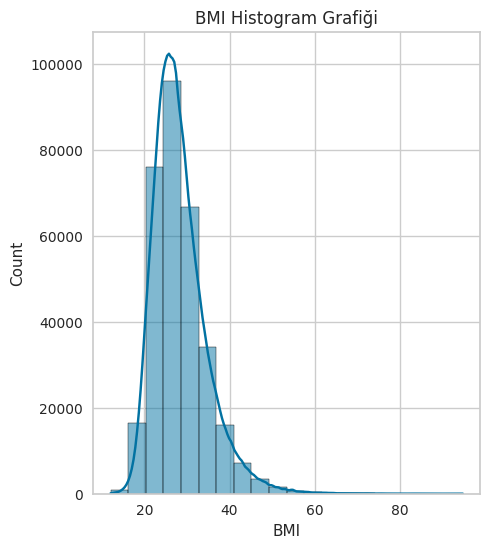

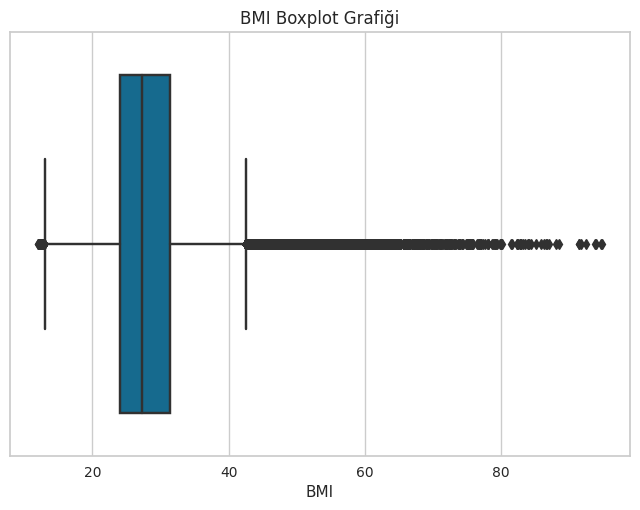

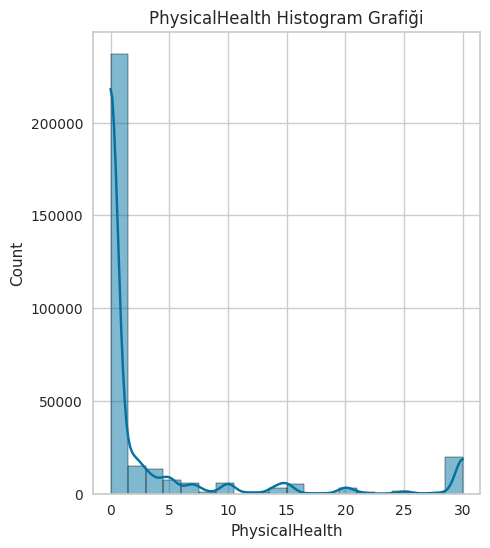

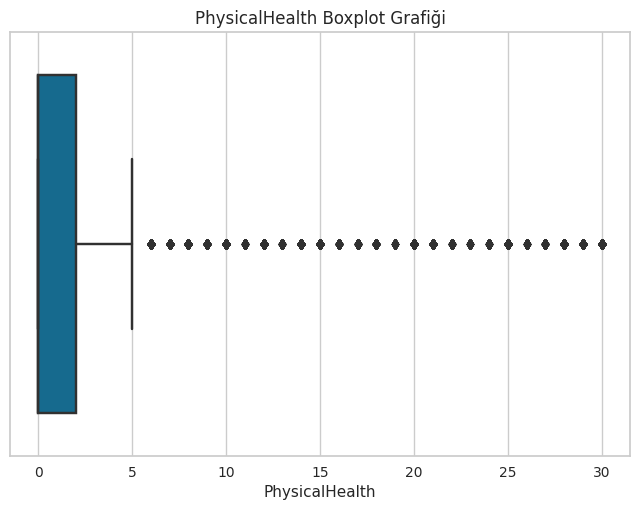

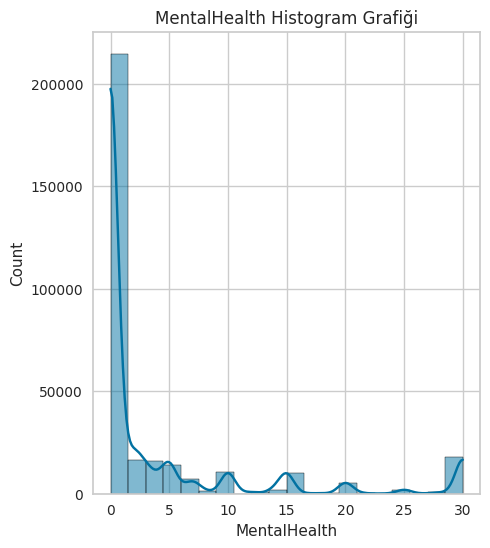

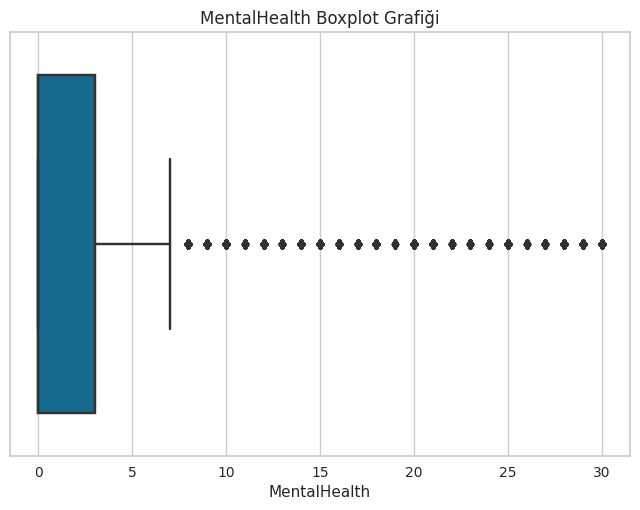

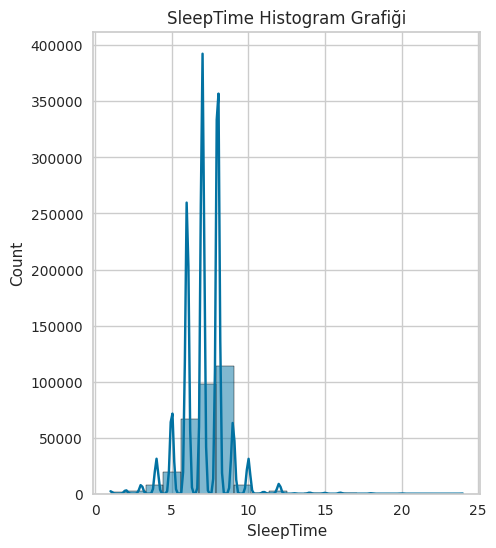

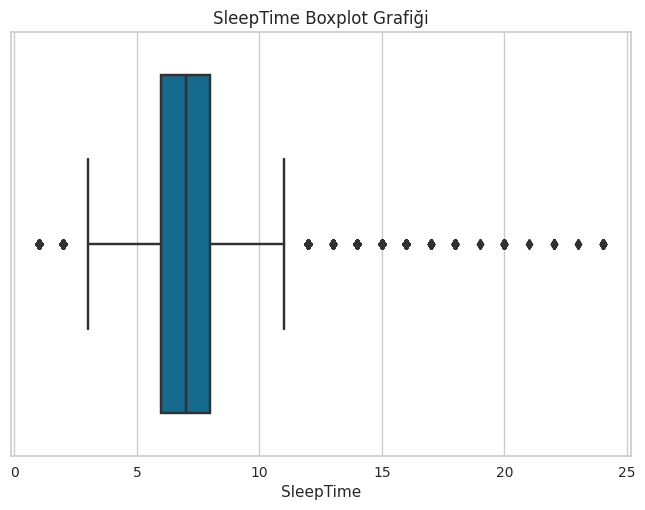

In [41]:
for col in num_col :
    plt.figure(figsize =(5,6))
    sns.histplot(df[col],kde = True,bins =20)
    plt.title(col + " Histogram Grafiği")
    plt.show()
    sns.boxplot(x=df[col])
    plt.title(col + " Boxplot Grafiği")
    plt.show()
    print("\n\n")
    

Nümerik sütunlarımızı histogram ve boxplot grafikleri ile görselleştirdik.Histogram grafiği bize verilerin frekansını gösterirken boxplot grafiği veri çeyrekliklerini (%25,%50,%75,min,max değerlerini), aykırı değerleri gözlemlememizde yardımcı olur.

* BMI için histogram grafiğinden en sık değerin 30 civarlarında olduğunu çıkarabiliriz. Boxplot grafiğine baktığımızda ise kutunun ortasındaki çizgi bize medyan değerini gösterir ve simetrik bir dağılım olduğu sonucuna varabiliriz.Kutunun yanında olan iki çizgi min ve max değerlerimizi bu çizgilerin dışında kalan noktalar ise aykırı değerleri ifade etmektedir.BMI için aykırı değerlerimizin olduğu gözlemini yapabiliriz.

* PhysicalHealth için histogram grafiğinden en sık değerin 0-5 arasında olduğunu görüyoruz.Boxplot grafiğinde ise medyan değerinin kutunun ortasında olmadığını görüyoruz yani bu sütunda veriler için asimetrik bir dağılım söz konusu. BMI kadar çok olmasa da yine aykırı değerlerimiz bulunmakta.

* MentalHealth sütunu da PhysicalHealth sütununa benzer en sık değer 0-5 arasında asimetrik bir dağılım ve aykırı değerler söz konusu.

* SleepTime için en sık görülen değer 7 civarındadır.Simetrik bir dağılım söz konusu olup aykırı değerler bulunur.

**Kategorik Değişkenlerimizin Görselleştirilmesi**

In [42]:
cat_col = [ col for col in df.columns if df[col].dtypes == "O"]
cat_col

['HeartDisease',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

Veri tipi object olan yani kategorik sütunlarımızı belirledik.

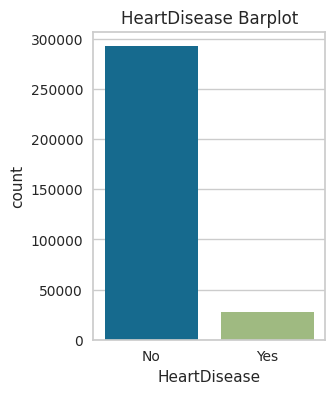

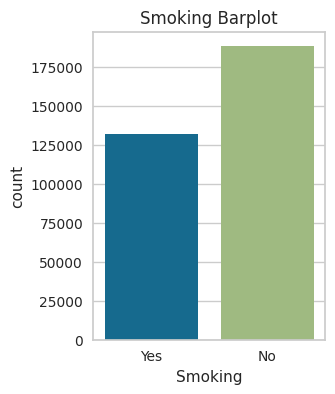

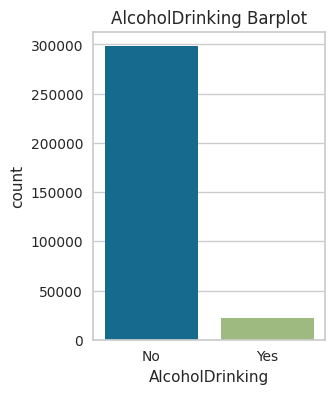

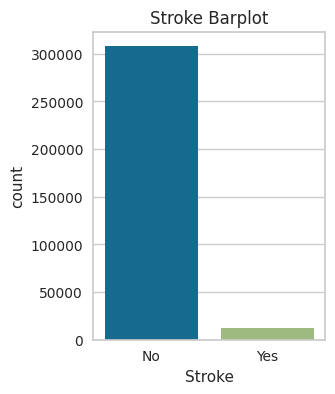

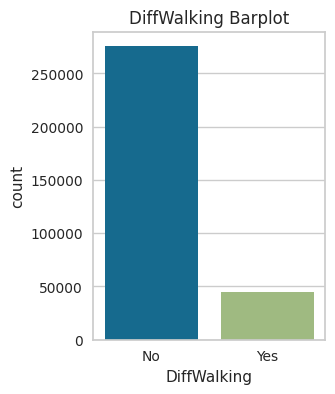

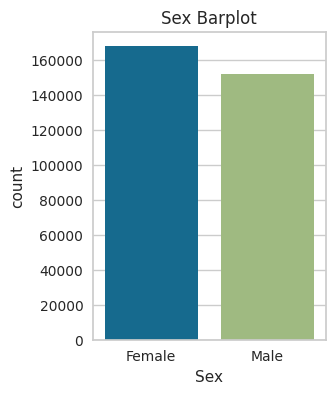

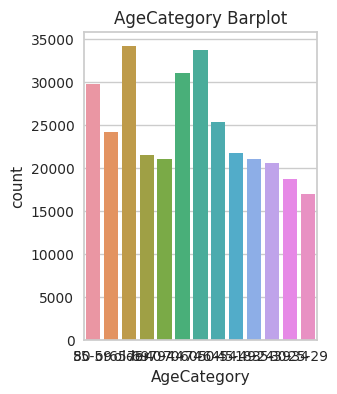

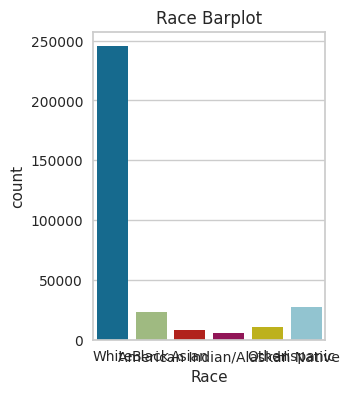

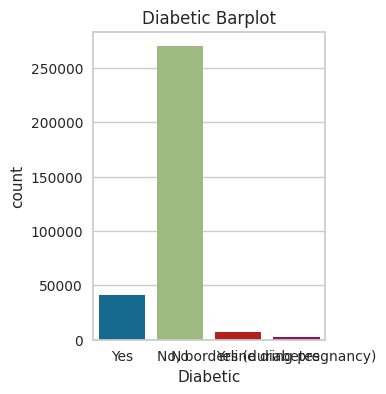

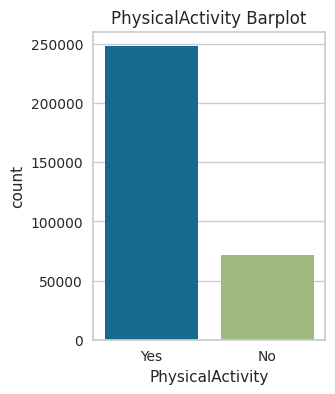

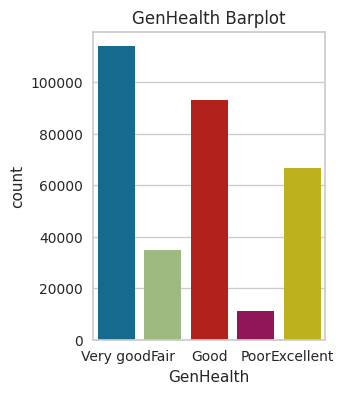

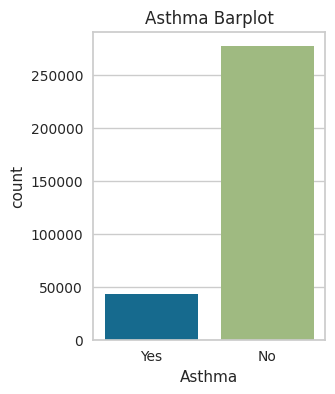

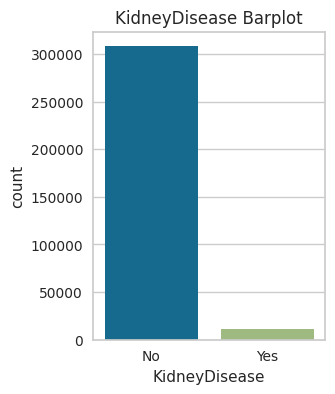

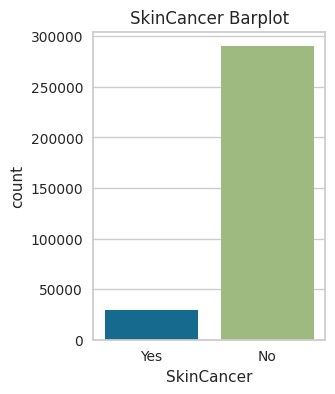

In [43]:
for col in cat_col:
    plt.figure(figsize=(3,4))
    sns.countplot(x=df[col])
    plt.title(col + " Barplot")
    plt.show()

Kategorik sütunları görselleştirdik.
* HeartDisease: Kalp hastalığı bulunmayan hastalar bulunanlara göre çok büyük bir çoğunlukta.
* Smoking: Sigara içmeyenler içenlere göre daha fazla.
* AlcoholDrinking: Alkol içmeyenler daha fazla.
* Stroke: Felç geçirmeyenler daha fazla.
* DiffWalking: Yürümekte zorluk çekmeyenler daha fazla.
* Sex: Kadın erkek dağılımı birbirine yakın fakat kadınlar daha fazla.
* Race: Beyaz ırk daha fazla.
* Diabetic: Diyabetik olmayanlar daha fazla.
* PhysicalActivity: Extra fiziksel aktivitede bulunanlar daha fazla.
* GenHealth: Genel sağlık durumunu iyi olarak tanımlayanlar tanımlamayanlara göre daha fazla.
* Asthma: Astımı olmayanlar daha fazla.
* SkinCancer: Cilt kanseri geçirmemiş olanlar daha fazla.

Genel olarak gözlemlediğimizde kategorik değişkenlerde dengesiz bir dağılım var.

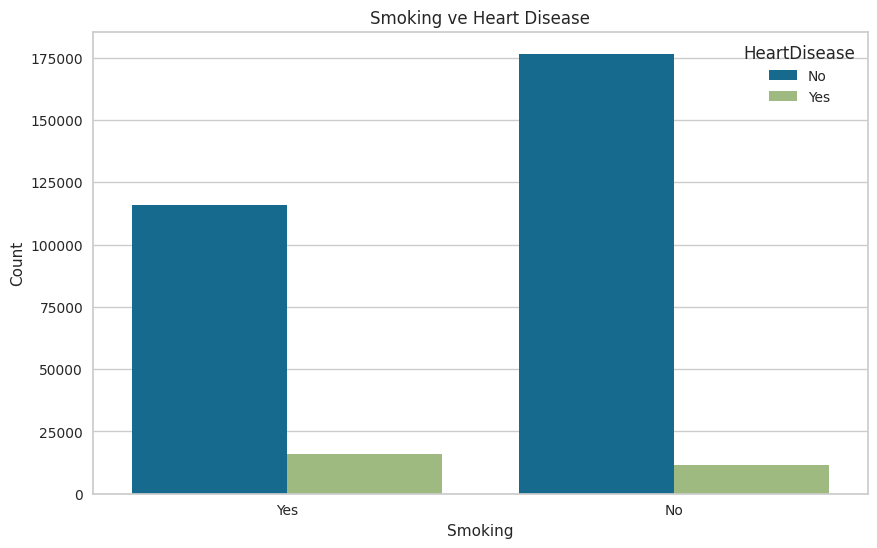

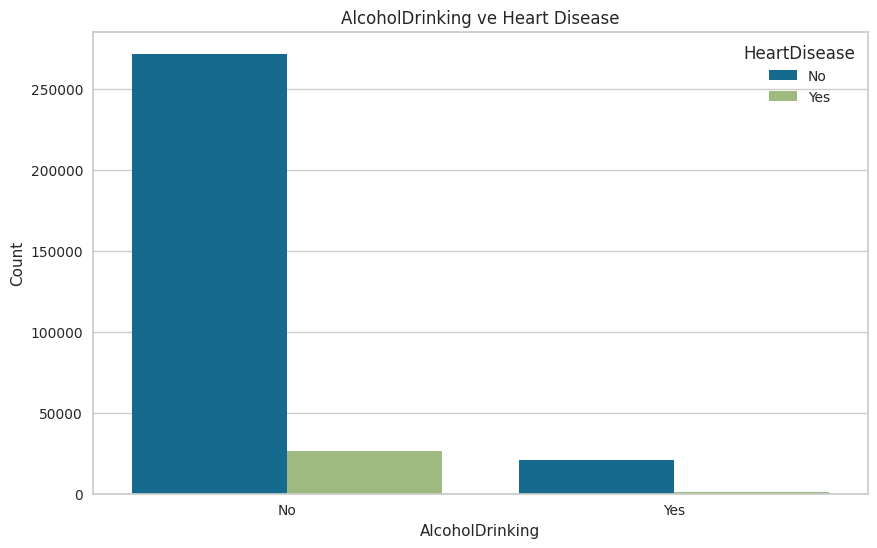

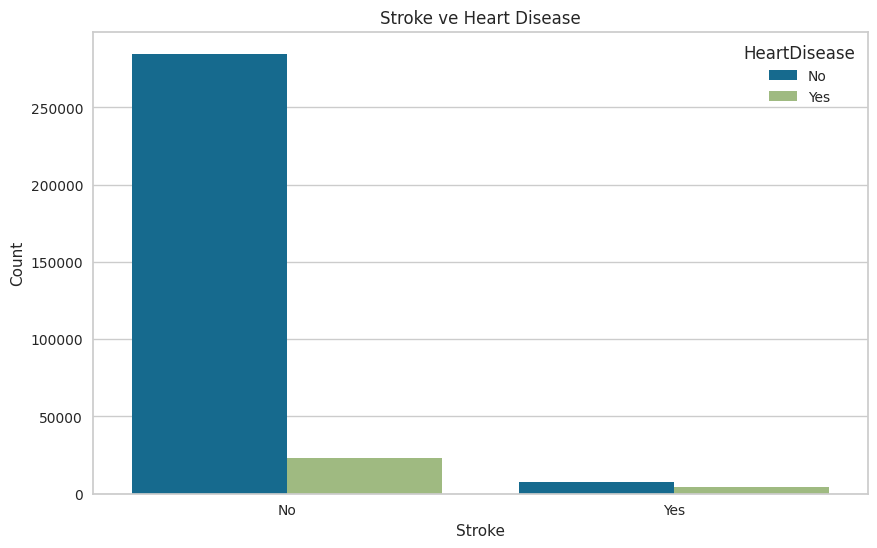

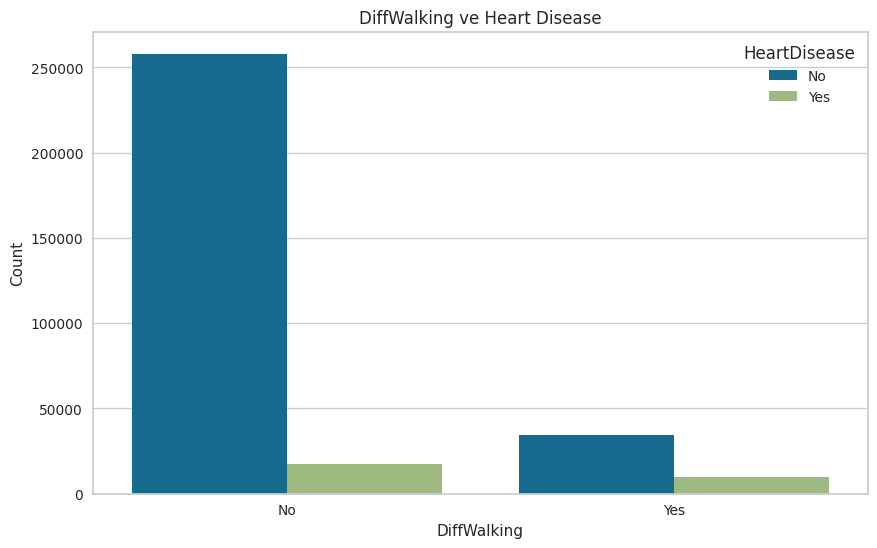

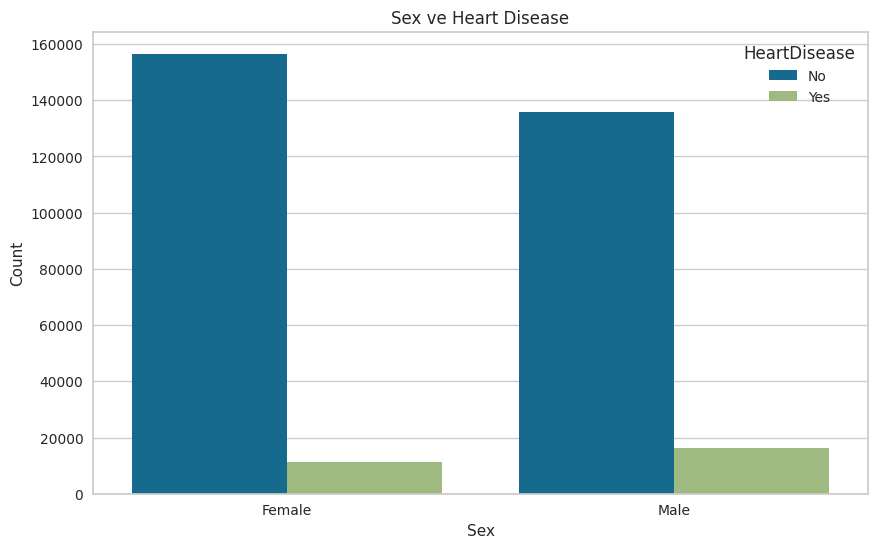

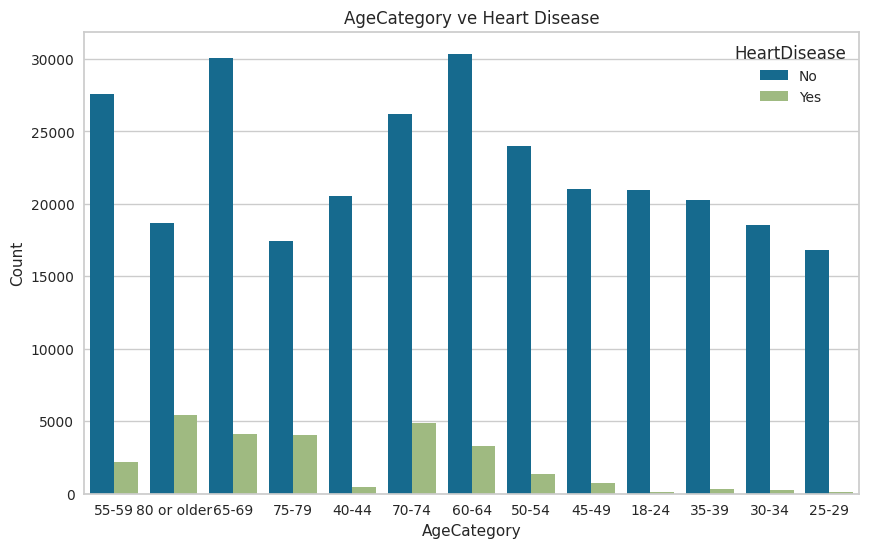

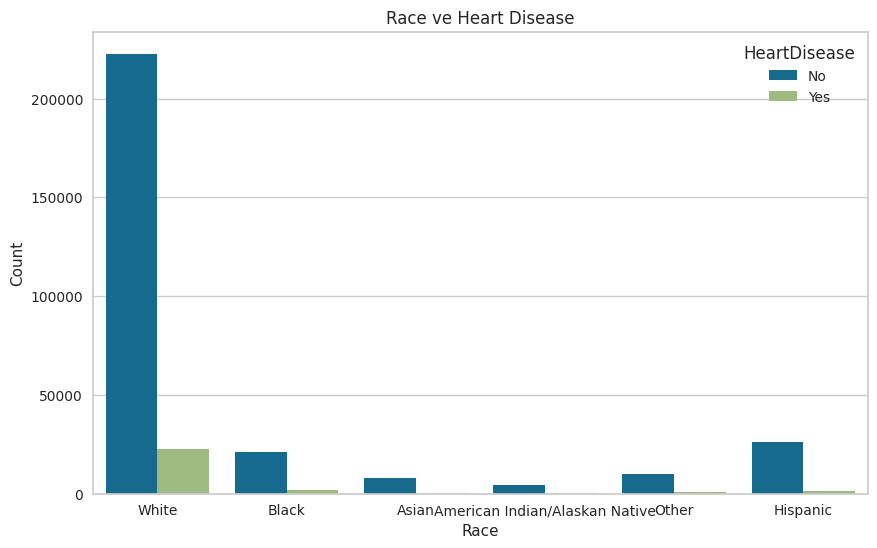

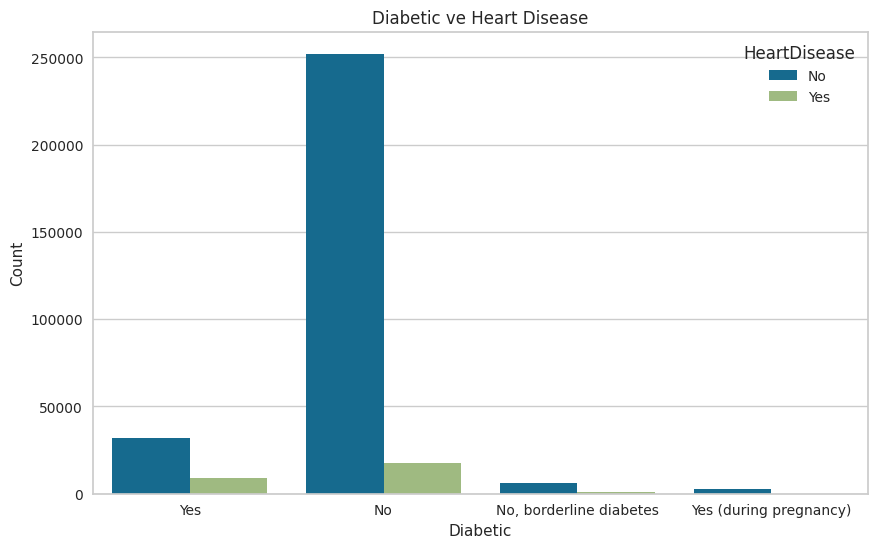

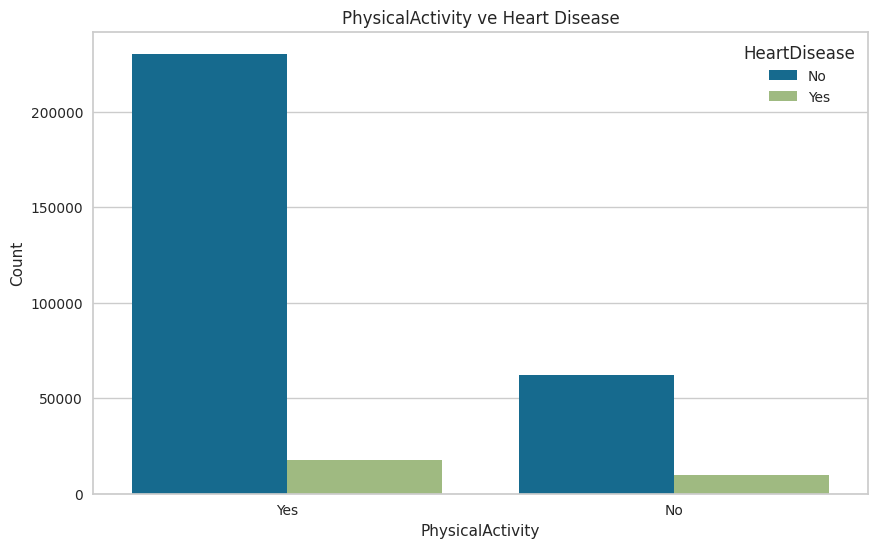

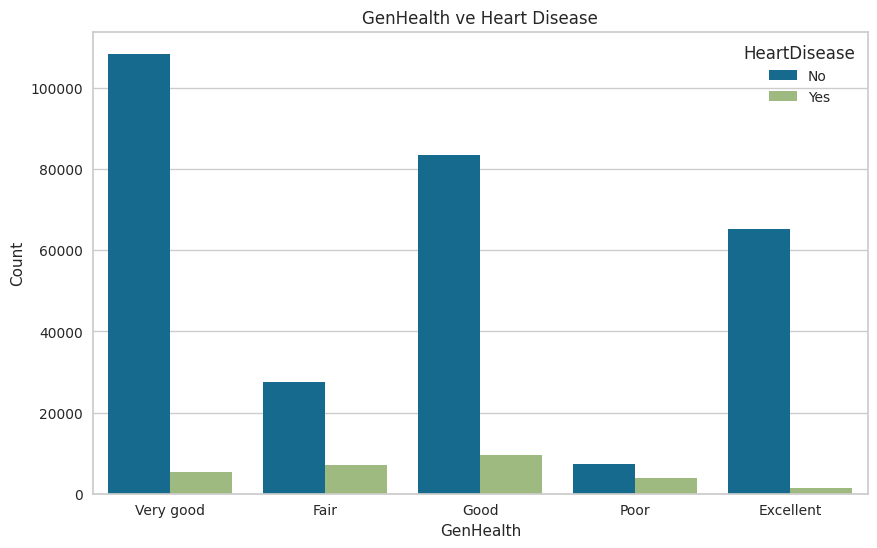

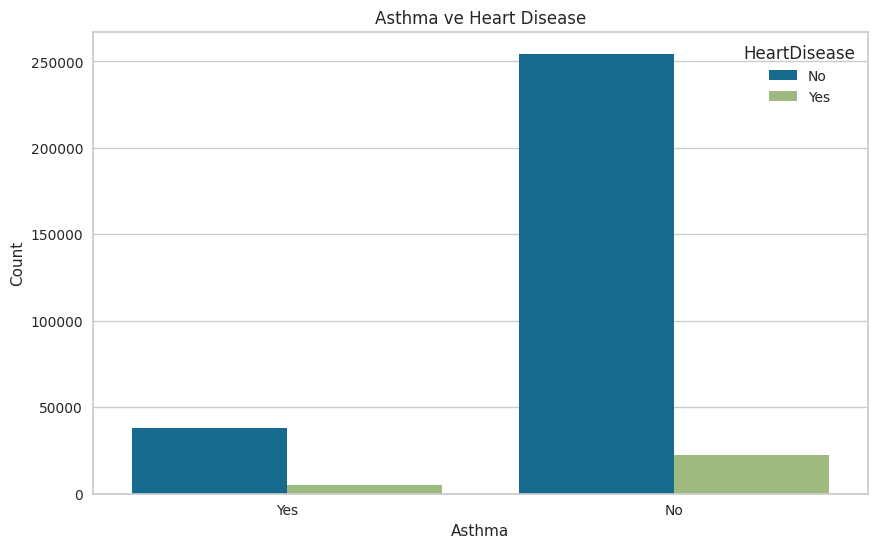

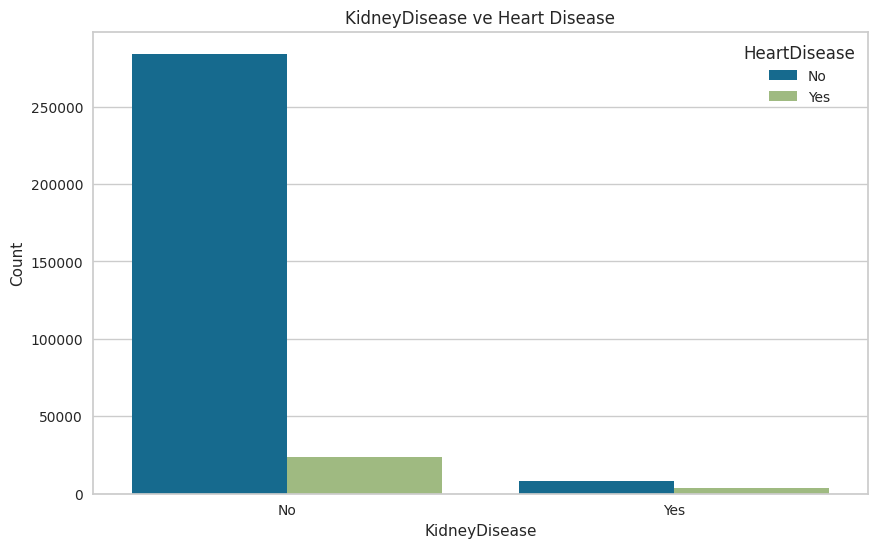

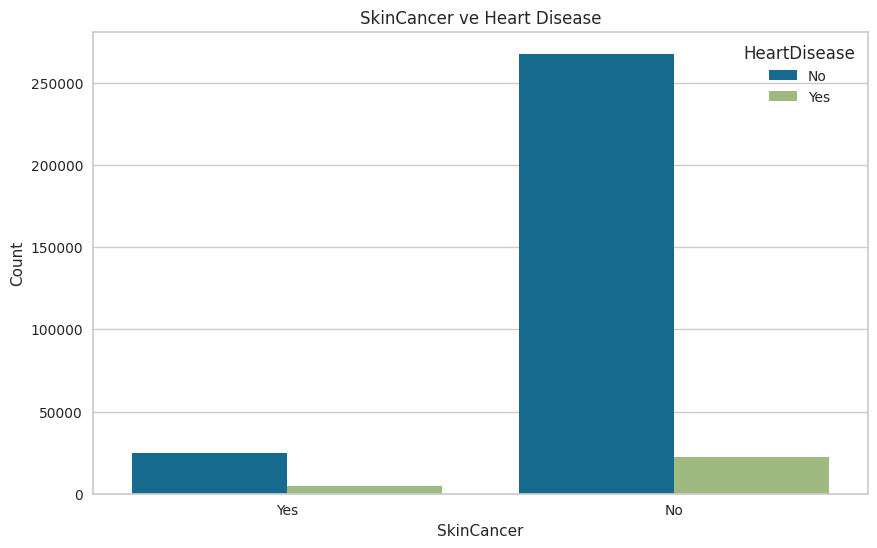

In [44]:

cat_col2 = cat_col.copy()  
cat_col2.remove("HeartDisease")

for col in cat_col2:
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x=col, hue='HeartDisease')  
    plt.title(f'{col} ve Heart Disease')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()
    



Diğer kategorik değişkenlerimizin HearthDisease üzerinde dağılımını görselleştirdik.


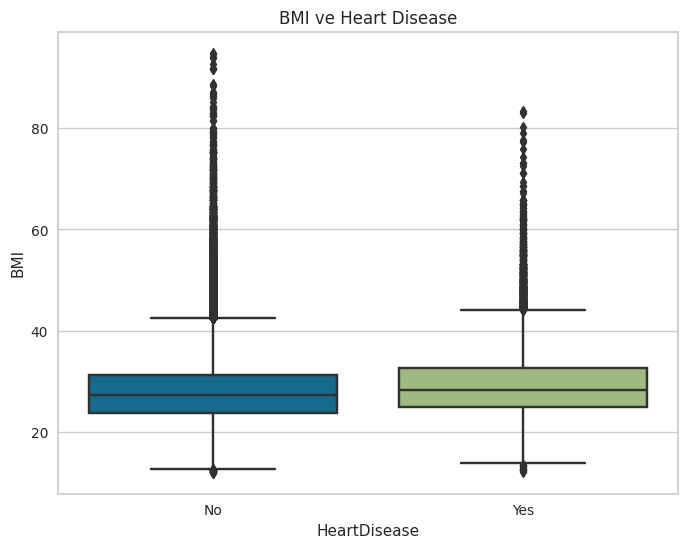

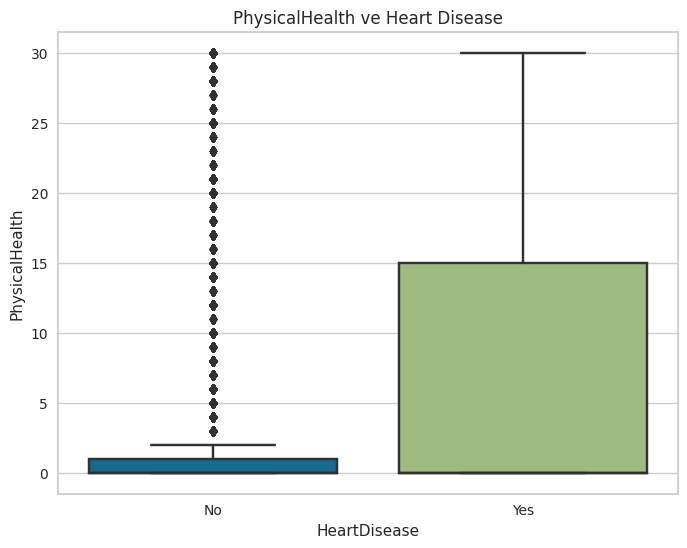

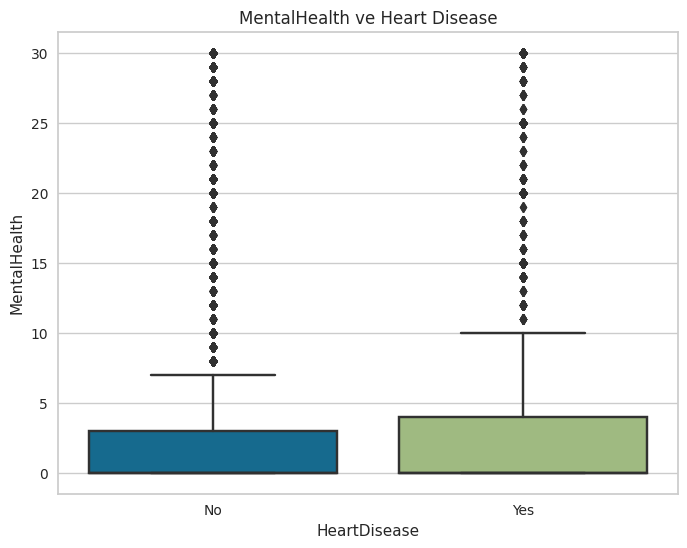

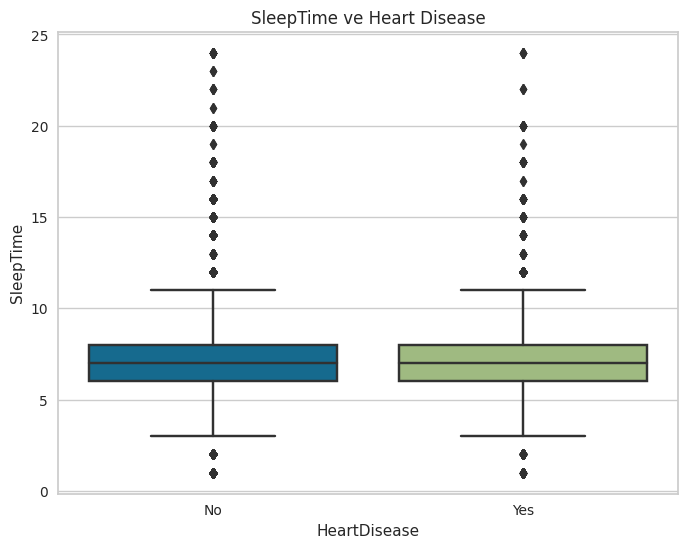

In [45]:
for col in num_col:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=df, x="HeartDisease", y=col)
    plt.title(f"{col} ve Heart Disease")
    plt.xlabel("HeartDisease")
    plt.ylabel(col)
    plt.show()
    

Kalp hastalığı olanların ve olmayanların BMI,PhysicalHealth,MentalHealth,SleepTime üzerindeki dağılımını gözlemledik.
* BMI: Kalp hastalığı olan ve olmayanlardaki BMI aralığı birbiriyle neredeyse aynı.
* PhysicalHealth: Kalp hastalığı olan kişilerin fiziksel sağlıklarının dağılımı 0-15 arasında genişken olmayan kişilerin 0-2 civarında.
* MenthalHealth: Kalp hastalığı olan ve olmayanlardaki MenthalHealth aralığı birbiriyle yakın.
* SleepTime: Kalp hastalığı olan ve olmayanlardaki SleepTime aralığı birbiriyle aynı, oldukça eşit bir dağılım var.

**Korelasyon Matrisi**

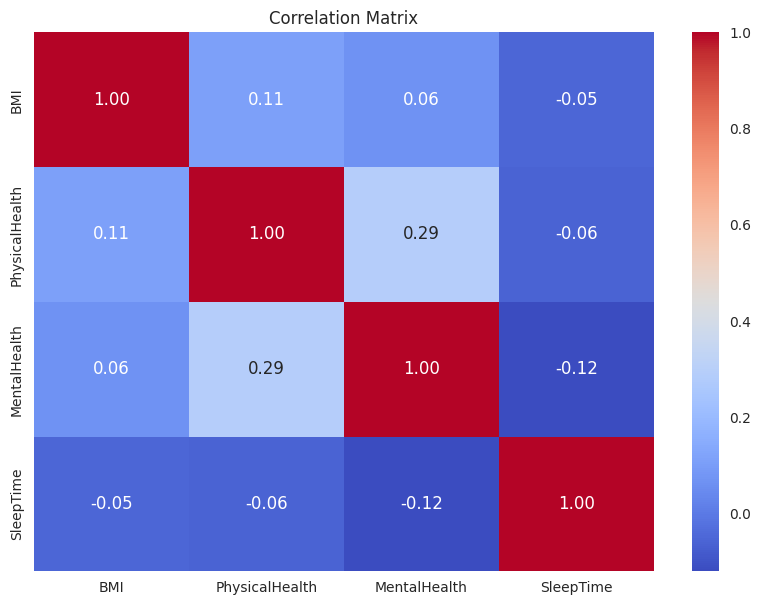

In [46]:
corr= df[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Korelasyon matrisi kullanarak değişkenlerin arasındaki ilişkileri gözlemledik. Genel olarak değişkenler arasında anlamlı bir doğrusal ilişki yok.

# Veri Ön İşleme

In [47]:
df.duplicated().sum()

18078

Tekrarlanan verilerin toplamını bulduk

In [48]:
df = df.drop_duplicates()
df.shape

(301717, 18)

Bu verileri veri setimizden çıkararak temizledik.

**Aykırı Değer(Outlier) Bulma**

In [49]:
for col in num_col:
    quartile1 = df[col].quantile(0.25)
    quartile3 = df[col].quantile(0.75)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    print(col,":", low_limit, up_limit)
    if df[(df[col] > up_limit) | (df[col] < low_limit)].any(axis=None):
        ouitlers =df[(df[col] > up_limit) | (df[col] < low_limit)]
        print(col,"sütununda",ouitlers.shape[0]," adet aykırı değerler var!")
        df.loc[(df[col]<low_limit),col] = low_limit
        df.loc[(df[col]>up_limit),col] = up_limit
        if df[(df[col] > up_limit) | (df[col] < low_limit)].shape[0] == 0:
            print(col," sütununa ait aykırı değerler temizlendi.\n")
        

BMI : 12.600000000000005 43.08
BMI sütununda 8905  adet aykırı değerler var!
BMI  sütununa ait aykırı değerler temizlendi.

PhysicalHealth : -3.0 5.0
PhysicalHealth sütununda 47136  adet aykırı değerler var!
PhysicalHealth  sütununa ait aykırı değerler temizlendi.

MentalHealth : -6.0 10.0
MentalHealth sütununda 39713  adet aykırı değerler var!
MentalHealth  sütununa ait aykırı değerler temizlendi.

SleepTime : 3.0 11.0
SleepTime sütununda 4542  adet aykırı değerler var!
SleepTime  sütununa ait aykırı değerler temizlendi.



Aykırı değerleri bulmak için her bir sütundaki alt ve üst limitleri belirledik ve bu limitlerin dışında kalan değerlerin olup olmadığını tespit ettik. Daha sonra bu değerleri limit değerlerine eşitleyerek aykırı değerleri temizledik. Bu sütunlara ait aykırı değerler olduğunu boxplot grafiği yardımıyla zaten gözlemlemiştik.

**Label Encoder**

In [50]:
for col in cat_col:
    print(df[col].value_counts())
    print("\n")

HeartDisease
No     274456
Yes     27261
Name: count, dtype: int64


Smoking
No     174312
Yes    127405
Name: count, dtype: int64


AlcoholDrinking
No     280136
Yes     21581
Name: count, dtype: int64


Stroke
No     289653
Yes     12064
Name: count, dtype: int64


DiffWalking
No     257362
Yes     44355
Name: count, dtype: int64


Sex
Female    159671
Male      142046
Name: count, dtype: int64


AgeCategory
65-69          31670
60-64          31219
70-74          29273
55-59          27610
50-54          23736
80 or older    23352
75-79          20713
45-49          20518
18-24          19998
40-44          19837
35-39          19526
30-34          17953
25-29          16312
Name: count, dtype: int64


Race
White                             227724
Hispanic                           27107
Black                              22810
Other                              10891
Asian                               7993
American Indian/Alaskan Native      5192
Name: count, dtype: int64


Diabet

Kategorik değişkenlerimizdeki değerleri gözlemledik. Veri setimiz dengesiz bir veri seti. Yani kalp hastalığına sahip olmayanlarla ilgili daha fazla gözlem varken sahip olanlarla ilgili çok az bir gözlem bulunmakta.

In [51]:
df['HeartDisease'] = df['HeartDisease'].map({"Yes":1,"No":0})
df['Smoking'] = df['Smoking'].map({"Yes":1,"No":0})
df['AlcoholDrinking'] = df['AlcoholDrinking'].map({"Yes":1,"No":0})
df['Stroke'] = df['Stroke'].map({"Yes":1,"No":0})
df['DiffWalking'] = df['DiffWalking'].map({"Yes":1,"No":0})
df['PhysicalActivity'] = df['PhysicalActivity'].map({"Yes":1,"No":0})
df['Asthma'] = df['Asthma'].map({"Yes":1,"No":0})
df['KidneyDisease'] = df['KidneyDisease'].map({"Yes":1,"No":0})
df['SkinCancer'] = df['SkinCancer'].map({"Yes":1,"No":0})
df['Sex'] = df['Sex'].map({"Female":1,"Male":0})

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,10.0,0,1,55-59,White,Yes,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,1,80 or older,White,No,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,5.0,10.0,0,0,65-69,White,Yes,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,1,75-79,White,No,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,5.0,0.0,1,1,40-44,White,No,1,Very good,8.0,0,0,0


Kategorik değişkenlerimizde ikili(binary) şekilde gözlemlere sahip olan satırları sayısal bir şekilde ifade etmemiz gerekiyor. Bunun için 'No'değerini 0 'Yes' değerini 1 ile değiştiriyoruz. Aynısını 'Sex' sütunumuz içinde uyguluyoruz.

In [52]:
le = LabelEncoder()

df["AgeCategory"] = le.fit_transform(df["AgeCategory"])
df["Race"] = le.fit_transform(df["Race"])
df["Diabetic"] = le.fit_transform(df["Diabetic"])
df["GenHealth"] = le.fit_transform(df["GenHealth"])

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,10.0,0,1,7,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,1,12,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,5.0,10.0,0,0,9,5,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,1,11,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,5.0,0.0,1,1,4,5,0,1,4,8.0,0,0,0


Kalan kategorik değişkenlerimize label encoder uyguluyoruz. Sıralı bir şekilde değer atıyor.

# Supervised Learning (Denetimli Öğrenme)

In [53]:
y = df["HeartDisease"]
X = df.drop(["HeartDisease"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=42)
standart = StandardScaler()
X_train = standart.fit_transform(X_train)
X_test = standart.transform(X_test)

log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print(classification_report(y_test, y_pred)) 


              precision    recall  f1-score   support

           0       0.92      0.99      0.95     54894
           1       0.50      0.09      0.15      5450

    accuracy                           0.91     60344
   macro avg       0.71      0.54      0.55     60344
weighted avg       0.88      0.91      0.88     60344



Bağımsız ve bağımlı değişkenlerimizi belirliyoruz. Daha sonra veri setinin %20 sini test, %80 ini train yani eğitmek için ayırıyoruz. Veri setimizde bağımsız değişkenimize standartlaşma işlemini uyguluyarak belirli bir ölçeğe getiriyoruz. Lojistic Regresyon yöntemini uygulayarak test setimizdeki X lere göre tahmin işlemiyle y leri tahmin ediyoruz. Daha sonra bu yöntemin başarısını ölçmek için classification_report ile test setimizdeki y değerlerini tahmin ettiklerimizle karşılaştırıyoruz.

* Precision: Modelin pozitif tahmin ettiği örneklerden doğru tahmin ettiğimizin oranıdır.(TP/TP+FP)
* Recall: Pozitif tahmin etmemiz gereken örneklerin ne kadarını pozitif tahmin ettiğimizi gösterir.(TP/TP+FN)
* F1-Score: Precision ve Recall değerlerinin harmonik ortalamasıdır.
* Accuracy: Doğru tahmin ettiğimiz alanların hepsine oranıdır.(TP+TN/TP+TN+FP+FN)

Değerlerimizi incelediğimizde 0 sınıfı için precision,recall,f1-score değerleri çok yüksek yani bu sınıfı model iyi bir şekilde tahmin ediyor. Fakat 1 sınıfı için değerlerimiz oldukça düşük. Bu sorunun nedeni veri setimizin dengesiz olması. Kalp hastalığına sahip olanların gözlem sayısı olmayanlara göre azınlıkta olduğu için modelimiz iyi çalışmıyor.


In [54]:

smote = SMOTE(random_state=42)


x_train_2, y_train_2 = smote.fit_resample(X_train, y_train)


print('Önceki gözlem sayısı:', Counter(y_train))
print('Sonraki gözlem sayısı:', Counter(y_train_2))

log_model2 = LogisticRegression(random_state = 0)
log_model2.fit(x_train_2, y_train_2)
y_pred_2= log_model2.predict(X_test)
print(classification_report(y_test, y_pred_2)) 


Önceki gözlem sayısı: Counter({0: 219562, 1: 21811})
Sonraki gözlem sayısı: Counter({0: 219562, 1: 219562})
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     54894
           1       0.22      0.75      0.34      5450

    accuracy                           0.73     60344
   macro avg       0.59      0.74      0.58     60344
weighted avg       0.90      0.73      0.79     60344



Smote yöntemi ile azınlık sınıfındaki örnekleri arttırarak veri setimizi daha dengeli bir hale getirebiliriz. Smote uyguladıktan sonra bağımlı değişkenimizin gözlem sayısı arttı. Recall değerimiz arttı fakat precision değerimiz düştü. Sonuç olarak eskisinden daha başarılı bir sonuç elde ettik.

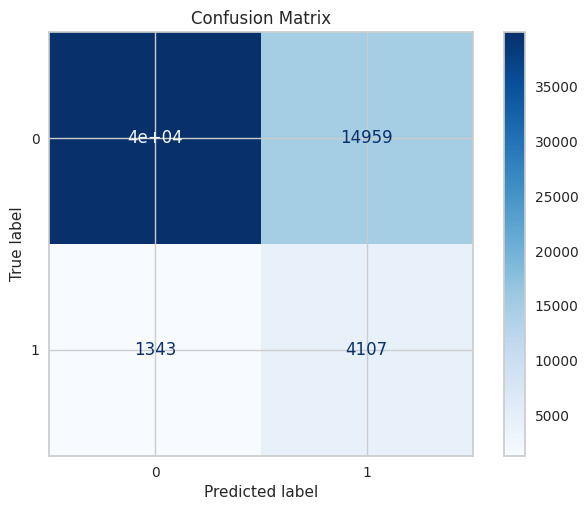

In [55]:
cm = confusion_matrix(y_test, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

TN,FP,FN,TP değerlerimizin gösterildiği confusion matriximiz. Burdan da gözlemleyebileceğimiz gibi 1 sınıfına ait tahminler açık renkte yani daha az sayıda doğru veya yanlış tahmin yapılmış.

# Unsupervised Learning (Denetimsiz Öğrenme)

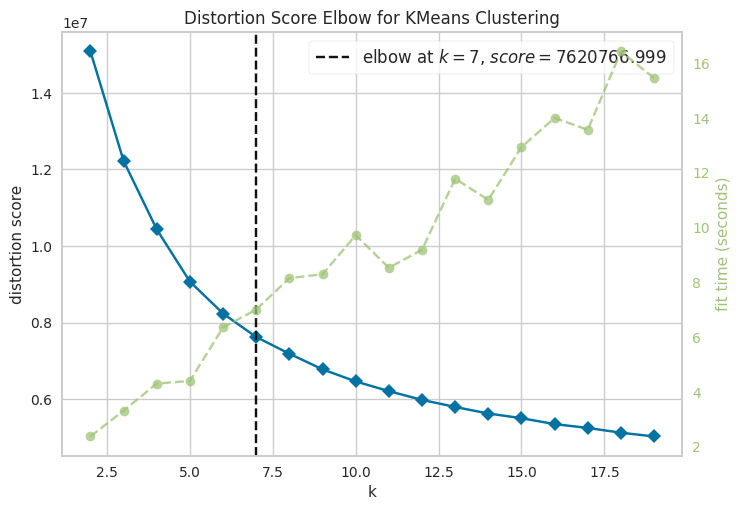

7

In [56]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(X)
elbow.show()

elbow.elbow_value_

KMeans kümeleme yönteminde elbow yani dirsek yöntemi ile küme sayısını belirliyoruz. Küme sayısı arttıkça kümeler arası uyumsuzluk azalır. Kümeler arası uyumsuzluk değerinin en hızlı şekilde düştüğü ve azalmanın yavaşladığı noktadaki küme sayısı bizim için en uygun küme sayısıdır. Bu grafik üzerindeki bu sayı 7 dir.

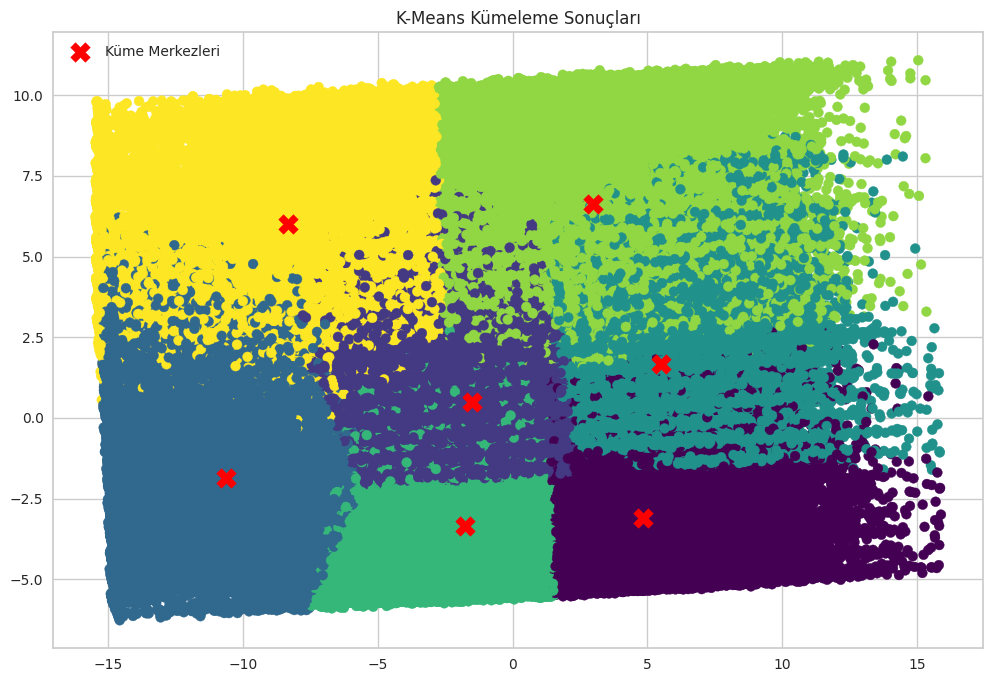

In [57]:
kmeans = KMeans(n_clusters =7,random_state=42)
kmeans.fit(X)
labels=kmeans.labels_
centers =kmeans.cluster_centers_

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)
x = pca_data[:, 0]
Y = pca_data[:, 1]

plt.figure(figsize=(12, 8))
plt.scatter(x, Y, c=labels, s=50, cmap='viridis')
plt.scatter(pca.transform(centers)[:, 0], pca.transform(centers)[:, 1], c='red', s=200, marker='X', label='Küme Merkezleri')
plt.title('K-Means Kümeleme Sonuçları')
plt.legend()
plt.grid(True)
plt.show()


Bulduğumuz küme sayısıyla KMeans yöntemini uygulayalım. Daha sonra PCA yöntemi ile 2 boyuta indirgeyerek grafik oluşturalım. Karşımıza çıkan grafikte kümeler birbiriyle örtüşmekte ve kümeler arasında net bir ayrım yok. Kümeleme yöntemi bu veri seti için çok iyi bir sonuç vermemiş.

In [58]:
print("Adjusted Rand Index:", adjusted_rand_score(y,labels))
print("V-Measure Skoru:", v_measure_score(y, labels))


Adjusted Rand Index: -0.002712137955252344
V-Measure Skoru: 0.017891123777000237


* Adjusted Rand Index: Gerçek sınıf etiketleri ile kümeler arasındaki benzerliği ölçer. 
* V-Measure Skoru: Kümeleme sonucunun hem homejenliğini hem de kapsamını ölçer.

İki sonucumuzda düşük. KMeans bu veri setinde kötü bir sonuç verdi.